# Imports

In [1]:
import fluids
import gradient_calc as gc
import gradient_functions as gf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import scipy.constants as SPC

# Parameters

In [3]:
D = 1.995 * SPC.inch
x = [-1015, 0]
eps = 0.045e-3
tubing = gc.Tubing(D=D,eps=eps,x_points=x, k=1)
print('Area:', tubing.get_area())
tubing.get_inclination(-10)


Area: 0.0020167084344950184


array(1.)

In [4]:
T = SPC.convert_temperature(25, 'C', 'K')
print(T)
gas = fluids.Gas(composition={'C1': 1}, ref_T=T)
water = fluids.Water(salinity=90, ref_T=T)
print(gas.get_standard_density(), water.get_density(SPC.atm))

298.15
0.6784908149356519 1054.6881293842014


In [5]:
vlp = gc.BiPhaseVLP(tubing, liquid=water, gas=gas, T=T, sigma_function = lambda P, T: 30,
                    payne_correction=False, holdup_adj=1)
vlp.solver_kwargs['method'] = 'BDF'

In [27]:
print('reference gas mass rate kg/s:', 100000 / SPC.day * gas.get_standard_density())


reference gas mass rate kg/s: 0.785290295064412


# Plots

In [13]:
def get_p_values(WGR, qgvalues=np.logspace(3, np.log10(40000), 10), THP=10*SPC.bar, BHP=False):
    qgvalues_mass = qgvalues / SPC.day * gas.get_standard_density()
    qwvalues_mass = qgvalues / SPC.day * WGR * water.get_standard_density()
    gp_args = dict(BHP=BHP) if BHP else dict(THP=THP)
    out = list()
    for qw, qg in zip(qwvalues_mass, qgvalues_mass):
        try:
            p = vlp.get_end_pressure([qw, qg], **gp_args)
            out.append(p)
        except:
            vlp.verbose=True
            p = vlp.get_end_pressure([qw, qg], **gp_args)
            raise
        finally:
            vlp.verbose=False
    return out

In [77]:
qgvalues = np.logspace(3, np.log10(40000), 20)
ps = list()
WGR_values = [0.01e-3, 0.1e-3, 0.5e-3, 1e-3]
THP_values = np.array([25])
for THP in THP_values:
    for WGR in WGR_values:
        ps.append([THP, WGR, np.array(get_p_values(WGR,qgvalues, THP=THP*SPC.bar)) / SPC.bar])
results = pd.DataFrame(ps, columns=['THP', 'WGR', 'Pwf'])
results.head(2)

,THP,WGR,Pwf
0,25,0.00001,"[31.20222650159088, 31.09124150210426, 30.9838..."
1,25,0.00010,"[40.30232418349148, 39.95688462698668, 39.6205..."


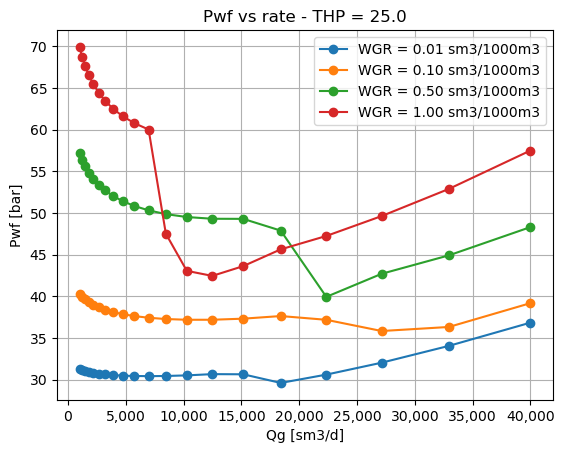

In [78]:
for THP in results.THP.unique():
    fig, ax = plt.subplots()
    sub = results[results.THP == THP]
    for _, r in sub.iterrows():
        ax.plot(qgvalues, r['Pwf'], label='WGR = {:.2f} sm3/1000m3'.format(r['WGR'] * 1000), marker='o')
    ax.set_xlabel('Qg [sm3/d]')
    ax.set_ylabel('Pwf [bar]')
    ax.grid()
    ax.legend(loc='best')
    ax.set_title('Pwf vs rate - THP = {:.1f}'.format(THP))
    ax.xaxis.set_major_formatter(tkr.FuncFormatter('{:,.0f}'.format))
print()

# Pandas

In [72]:
df = pd.read_clipboard(decimal=',', thousands='.')
print(df.columns)
print(df.dtypes)

Index(['t yrs', 't (days)', 'date', 'Pws (barA)', 'gas rate aQ Bq2',
       'Gas rate CN', 'Max Gas Rate', 'Gas Rate (sm3/d)', 'Pwf (barA)',
       '%DD well', 'Pwf res (bar A)', '%DD res', 'Pwh (barA)', 'GIP (MMm3)',
       'GP (MMm3)', 'RF%', 'z', 'Bg (rm3/sm3)', 'Mug', 'Sw', 'Sw*', 'Krg',
       'Krw', 'krw/krg', 'GWC (m)', 'Bot perf - GWC (m)', 'DD crit (barA)',
       'fwD - Coning adjustment', 'WGR (m3/sm3)', 'Water Rate (m3/d)',
       'Wp (MMm3)', 'P @ gwc', 'Paq (barA)', 'J', 'We (MMm3)', 'We/PV',
       'Delta We* (MM m3)', 'P GWC end *', 'Delta We** (MM m3)',
       'P GWC end **', 'Delta We (MM m3)', 'P/z', 'Pwh'],
      dtype='object')
t yrs                       object
t (days)                   float64
date                        object
Pws (barA)                 float64
gas rate aQ Bq2            float64
Gas rate CN                float64
Max Gas Rate                 int64
Gas Rate (sm3/d)             int64
Pwf (barA)                 float64
%DD well                    

In [73]:
out = list()
for i,r in df.iterrows():
    qgmass = r['Gas Rate (sm3/d)'] * gas.get_standard_density() / SPC.day
    qwmass = r['Water Rate (m3/d)'] * water.get_standard_density() / SPC.day + 1e-10
    if qgmass <= 0:
        break
    bhp = r['Pwf (barA)'] * SPC.bar
    thp = vlp.get_end_pressure([qwmass, qgmass], BHP=bhp)
    out.append(thp / SPC.bar)
    if i % 10 == 0:
        print(f'{i} ({bhp})', end='-')
print()


0 (9567000.0)-10 (8897000.0)-20 (8209000.0)-30 (7491000.0)-40 (6731000.0)-50 (5917000.0)-60 (5410000.0)-70 (5050000.0)-80 (4729000.0)-90 (4439000.0)-100 (4178000.0)-110 (3942000.0)-120 (3727000.0000000005)-130 (3531000.0)-140 (3352000.0000000005)-150 (3187000.0)-160 (3035000.0)-170 (2896000.0)-180 (2767000.0)-190 (2647000.0)-200 (2536000.0)-


In [74]:
pd.Series(out).to_clipboard(index=False, header=False, decimal=',')

# other

In [8]:
WGR = 1e-3
qvalues = np.logspace(3, np.log10(40000), 10)
THPref = 10 * SPC.bar
BHPref = 50 * SPC.bar

qgvalues_mass = qvalues / SPC.day * gas.get_standard_density()
vlp.verbose=False
out = {'BHP': dict(), 'THP': dict()}
for WGR in (0.01e-3, 0.1e-3, 0.5e-3, 1e-3):
    qwvalues_mass = qvalues / SPC.day * WGR * water.get_density(SPC.atm)
    BHPv = list()
    THPv = list()
    for qw, qg in zip(qwvalues_mass, qgvalues_mass):
        try:
            bhp = vlp.get_end_pressure([qw, qg], THP=THPref)
            #print(BHP)
            BHPv.append(bhp)
            thp = vlp.get_end_pressure([qw, qg], BHP=BHPref)
            THPv.append(thp)
        except:
            vlp.verbose=True
            thp = vlp.get_end_pressure([qw, qg], BHP=BHPref)
            raise
        finally:
            vlp.verbose=False
    print(thp/SPC.bar)
    out['BHP'][WGR] = np.array(BHPv) / SPC.bar
    out['THP'][WGR] = np.array(THPv) / SPC.bar

40.15236063864238
35.209197977719974
26.791116652706034
15.408392981490428


Text(0, 0.5, 'THP [bar]')

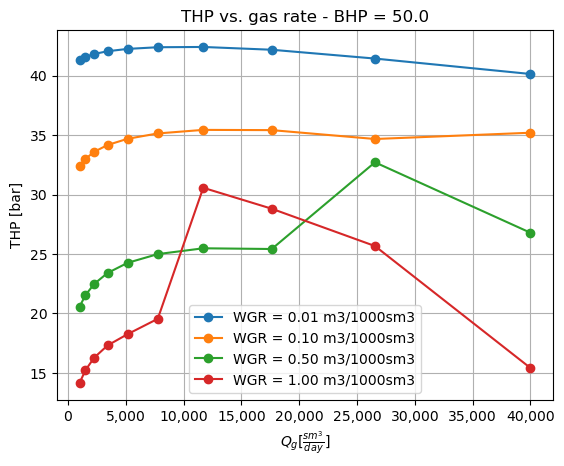

In [9]:
fig, ax = plt.subplots()
key = 'THP'
for WGR, val in out[key].items():
    ax.plot(qvalues, val, marker='o', label='WGR = {:.2f} m3/1000sm3'.format(WGR * 1000))

ax.set_title(f'{key} vs. gas rate - ' + '{} = {:.1f}'.format(*(('BHP', BHPref/1e5) if key == 'THP' else ('THP', THPref/1e5))))
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(tkr.FuncFormatter('{:,.0f}'.format))
ax.set_xlabel('$Q_g [\\frac{sm^3}{day}]$')
ax.set_ylabel(f'{key} [bar]')

Text(0, 0.5, 'BHP [bar]')

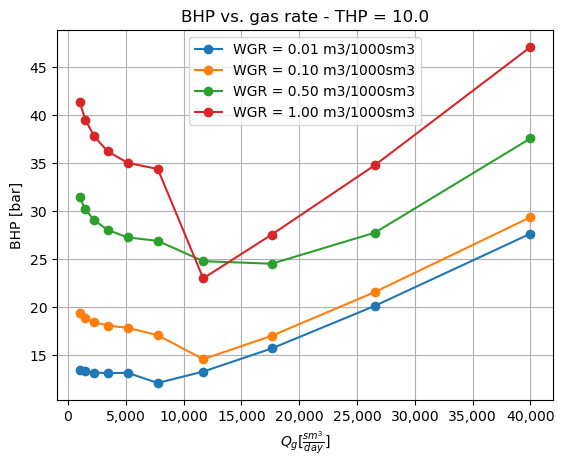

In [10]:
fig, ax = plt.subplots()
key = 'BHP'
for WGR, val in out[key].items():
    ax.plot(qvalues, val, marker='o', label='WGR = {:.2f} m3/1000sm3'.format(WGR * 1000))

ax.set_title(f'{key} vs. gas rate - ' + '{} = {:.1f}'.format(*(('BHP', BHPref/1e5) if key == 'THP' else ('THP', THPref/1e5))))
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(tkr.FuncFormatter('{:,.0f}'.format))
ax.set_xlabel('$Q_g [\\frac{sm^3}{day}]$')
ax.set_ylabel(f'{key} [bar]')

144